## Required PIP Installations in Terminal Before Running Code

In [2]:
# pip install gym-trading-env, torch
#  
# git clone https://github.com/facebookresearch/Pearl.git
# cd Pearl
# git install -e .
# cd ..


In [3]:
import gym_trading_env
from gym_trading_env.downloader import download, EXCHANGE_LIMIT_RATES
#import gymnasium as gym # No longer used and is installed with other libraries anyways
import gymnasium as gym
import datetime
import pandas as pd
import numpy as np
import os # used to get current directory
from tqdm import tqdm
# Import all the Pearl related methods
from pearl.pearl_agent import PearlAgent
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)
from pearl.policy_learners.sequential_decision_making.deep_q_learning import (
    DeepQLearning,
)
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import (
    FIFOOffPolicyReplayBuffer,
)
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from pearl.policy_learners.sequential_decision_making.implicit_q_learning import ImplicitQLearning
from pearl.utils.functional_utils.train_and_eval.offline_learning_and_evaluation import (
    get_offline_data_in_buffer,
    offline_evaluation,
    offline_learning,
)
from pearl.neural_networks.sequential_decision_making.actor_networks import VanillaContinuousActorNetwork
from pearl.pearl_agent import PearlAgent
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)
from pearl.policy_learners.sequential_decision_making.deep_q_learning import (
    DeepQLearning,
)
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import (
    FIFOOffPolicyReplayBuffer,
)
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
import torch # used for calculating the mean when evaluating Pearl training performance

##FOR USE WITH VANILLAQVALUENETWORK
#from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork

experiment_seed = 42

In [4]:
# Download data from site
EXCHANGE_LIMIT_RATES["binanceus"] = {
    "limit" : 200, # One request will query 200 data points (aka candlesticks).
    "pause_every" : 120, # it will pause every 120 requests.
    "pause" : 2, # the pause will last 2 seconds.
}
download(
    exchange_names = ["binanceus"],
    symbols= ["BTC/USDT"],
    timeframe= "1h",
    dir = "data",
    since= datetime.datetime(year= 2024, month= 8, day=7),
)

BTC/USDT downloaded from binanceus and stored at data/binanceus-BTCUSDT-1h.pkl


In [5]:
# Import data
filename = "./data/binanceus-BTCUSDT-1h.pkl"
df = pd.read_pickle(filename)

for item in df:
    print("The Item Is >>>>> " + item)
    

# df is a DataFrame with columns : "open", "high", "low", "close", "Volume USD"

#df.sort_index(inplace= True)

# Create the feature : ( close[t] - close[t-1] )/ close[t-1]
df["feature_close"] = df["close"].pct_change()

# Create the feature : open[t] / close[t]
df["feature_open"] = df["open"]/df["close"]

# Create the feature : high[t] / close[t]
df["feature_high"] = df["high"]/df["close"]

# Create the feature : low[t] / close[t]
df["feature_low"] = df["low"]/df["close"]

## simple moving averages
df["feature_sma10"] = df["close"].rolling(10).mean()
df["feature_sma5"] = df["close"].rolling(5).mean()

# Create the feature : volume[t] / max(*volume[t-7*24:t+1])
df["feature_volume"] = df["volume"] / df["volume"].rolling(2).max()

df.dropna(inplace= True) # Clean again !
# Each step, the environment will return 5 inputs  : "feature_close", "feature_open", "feature_high", "feature_low", "feature_volume"

df

The Item Is >>>>> open
The Item Is >>>>> high
The Item Is >>>>> low
The Item Is >>>>> close
The Item Is >>>>> volume
The Item Is >>>>> date_close


,open,high,low,close,volume,date_close,feature_close,feature_open,feature_high,feature_low,feature_sma10,feature_sma5,feature_volume
date_open,,,,,,,,,,,,,
2024-08-07 17:00:00,56136.58,56255.37,55425.30,55496.27,11.14794,2024-08-07 18:00:00,-0.010596,1.011538,1.013678,0.998721,56689.301,56127.654,1.000000
2024-08-07 18:00:00,55467.90,55500.00,54602.19,54724.60,4.17710,2024-08-07 19:00:00,-0.013905,1.013583,1.014169,0.997763,56429.957,55709.842,0.374697
2024-08-07 19:00:00,54683.49,55122.80,54683.49,54869.08,4.05487,2024-08-07 20:00:00,0.002640,0.996618,1.004624,0.996618,56180.700,55451.288,0.970738
2024-08-07 20:00:00,54865.54,55266.50,54670.73,55072.28,1.16852,2024-08-07 21:00:00,0.003703,0.996246,1.003527,0.992709,55957.132,55250.566,0.288177
2024-08-07 21:00:00,55127.27,55525.40,54884.41,55359.15,0.61045,2024-08-07 22:00:00,0.005209,0.995811,1.003003,0.991424,55793.536,55104.276,0.522413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-13 11:00:00,58318.48,58340.52,57849.48,57905.18,1.90824,2024-09-13 12:00:00,-0.006271,1.007138,1.007518,0.999038,57986.153,58059.206,1.000000
2024-09-13 12:00:00,57905.06,57954.42,57636.86,57947.90,0.23885,2024-09-13 13:00:00,0.000738,0.999261,1.000113,0.994632,57972.096,58033.968,0.125168
2024-09-13 13:00:00,57884.02,58123.56,57733.52,58073.76,0.21783,2024-09-13 14:00:00,0.002172,0.996733,1.000858,0.994141,57994.524,58050.926,0.911995


In [6]:
# df['close'].plot()

# df.index
split_date=pd.to_datetime('09/01/2024')
train_df=df[:split_date]
test_df=df[split_date:]


<Axes: xlabel='date_open'>

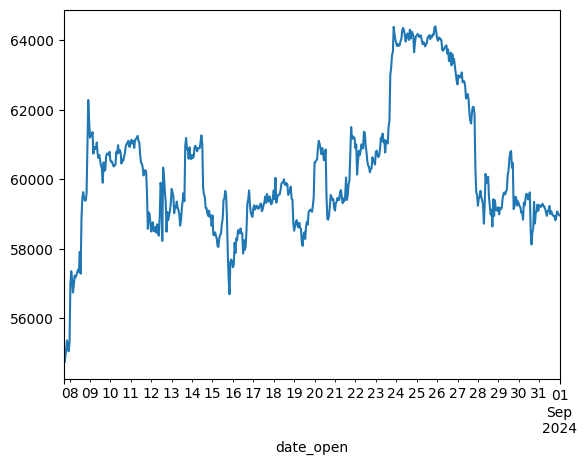

In [7]:
train_df['close'].plot()

In [8]:
## Create Trading Environment

# Define reward function here. Current function is based on last 2 timesteps (one hour apart)
def reward_function(history):
        return np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2])

train_env = gym.make("TradingEnv",
        name= "ICPUSD",
        df = train_df,
        positions = [ -1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        reward_function = reward_function,
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )

test_env = gym.make("TradingEnv",
        name= "ICPUSD",
        df = test_df,
        positions = [ -1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        reward_function = reward_function,
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )

In [9]:
obs,info=train_env.reset()
info

{'idx': 0,
 'step': 0,
 'date': np.datetime64('2024-08-07T17:00:00.000000000'),
 'position_index': 1,
 'position': np.int64(0),
 'real_position': np.int64(0),
 'data_high': 56255.37,
 'data_close': 55496.27,
 'data_low': 55425.3,
 'data_volume': 11.14794,
 'data_date_close': Timestamp('2024-08-07 18:00:00'),
 'data_open': 56136.58,
 'portfolio_valuation': 1000.0,
 'portfolio_distribution_asset': 0,
 'portfolio_distribution_fiat': np.float64(1000.0),
 'portfolio_distribution_borrowed_asset': 0,
 'portfolio_distribution_borrowed_fiat': 0,
 'portfolio_distribution_interest_asset': 0,
 'portfolio_distribution_interest_fiat': 0,
 'reward': 0}

## Make Wrapper Environment for Pearl

In [10]:
train_env = GymEnvironment(train_env)
test_env = GymEnvironment(test_env)

In [11]:
train_env

# episode
## Training_step
### loss_reduction 

In [12]:


num_actions = train_env.action_space.n
agent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=train_env.observation_space.shape[0],
        action_space=train_env.action_space, 
        hidden_dims=[64, 64],
        
        training_rounds=20,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
)


In [16]:
agent.policy_learner

DeepQLearning(
  (_action_representation_module): OneHotActionTensorRepresentationModule()
  (_history_summarization_module): IdentityHistorySummarizationModule()
  (_Q): VanillaQValueNetwork(
    (_model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=12, out_features=64, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (_Q_target): VanillaQValueNetwork(
    (_model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=12, out_features=64, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (safety_module): IdentitySafetyModule()
)

In [20]:

observation, action_space = train_env.reset()
observation.shape,action_space

((7,),
 <pearl.utils.instantiations.spaces.discrete_action.DiscreteActionSpace at 0x13b908490>)

In [21]:
agent.reset(observation, action_space)

In [22]:
action = agent.act(exploit=False)
action


tensor([1])

In [23]:
action_result = train_env.step(action)
action_result

ActionResult(observation=array([-9.3599118e-04,  1.0003542e+00,  1.0065527e+00,  9.9897468e-01,
        3.6814356e-01,  0.0000000e+00,  0.0000000e+00], dtype=float32), reward=np.float32(-0.000100005), terminated=False, truncated=False, info={'idx': 1, 'step': 1, 'date': np.datetime64('2024-08-07T10:00:00.000000000'), 'position_index': 1, 'position': 0, 'real_position': np.float64(0.0), 'data_volume': 0.25068, 'data_close': 57307.96, 'data_open': 57328.26, 'data_low': 57249.2, 'data_date_close': Timestamp('2024-08-07 11:00:00'), 'data_high': 57683.48, 'portfolio_valuation': np.float64(999.9), 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': np.float64(999.9), 'portfolio_distribution_borrowed_asset': 0, 'portfolio_distribution_borrowed_fiat': 0, 'portfolio_distribution_interest_asset': 0.0, 'portfolio_distribution_interest_fiat': 0.0, 'reward': np.float64(-0.00010000500033334732)}, cost=None, available_action_space=None)

In [25]:
losses=[]

In [26]:
n_epochs=5
for i in tqdm(range(n_epochs)):
    observation, action_space = train_env.reset()
    agent.reset(observation, action_space)
    done = False
    while not done:
        action = agent.act(exploit=False)
        action_result = train_env.step(action)
        agent.observe(action_result)
        loss=agent.learn()
        [losses.append(l) for l in loss['loss']]
        done = action_result.done


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
loss=agent.learn()
loss

{'loss': [0.0023811873979866505,
  0.0017646002816036344,
  0.0018055570544674993,
  0.002175847301259637,
  0.0022305184975266457,
  0.0020160991698503494,
  0.0020852205343544483,
  0.0021684723906219006,
  0.0024167594965547323,
  0.002101665362715721,
  0.0021944392938166857,
  0.0021747038699686527,
  0.0016727549955248833,
  0.0019049221882596612,
  0.002007229020819068,
  0.001832782756537199,
  0.0018944526091217995,
  0.0019050651462748647,
  0.0018286267295479774,
  0.0024245483800768852]}

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(losses)

59100

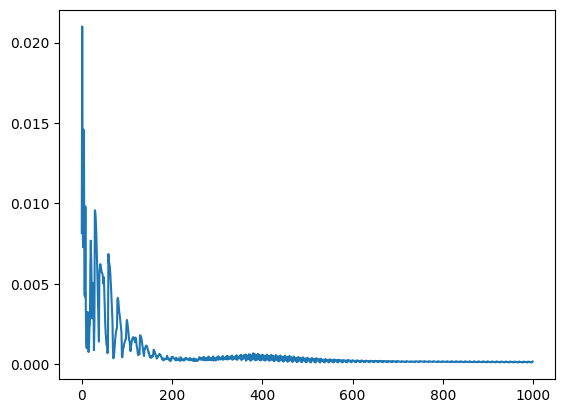

In [ ]:
plt.plot(losses[:1000])

In [ ]:
observation, action_space = train_env.reset()
agent.reset(observation, action_space)
done = False
while not done:
    action = agent.act(exploit=True)
    action_result = train_env.step(action)
    agent.observe(action_result)
    # loss=agent.learn()
    # [losses.append(l) for l in loss['loss']]
    done = action_result.done

Market Return :  2.78%   |   Portfolio Return : 12.65%   |   


In [ ]:
og_env=train_env.env.unwrapped

In [ ]:
og_env=train_env.env.unwrapped
og_env.save_for_render('renders/Train_run')

In [ ]:
from gym_trading_env.renderer import Renderer
renderer = Renderer(render_logs_dir="render_logs")

# Add Custom Lines (Simple Moving Average)
renderer.add_line( name= "sma10", function= lambda df : df["close"].rolling(10).mean(), line_options ={"width" : 1, "color": "purple"})
renderer.add_line( name= "sma20", function= lambda df : df["close"].rolling(20).mean(), line_options ={"width" : 1, "color": "blue"})

# renderer.run()

In [ ]:
observation, action_space = test_env.reset()
agent.reset(observation, action_space)
done = False
while not done:
    action = agent.act(exploit=True)
    action_result = test_env.step(action)
    agent.observe(action_result)
    # loss=agent.learn()
    done = action_result.done

Market Return : -8.10%   |   Portfolio Return :  7.74%   |   


In [ ]:
og_env=test_env.env.unwrapped
og_env.save_for_render('renders/Test_run')

In [ ]:
renderer = Renderer(render_logs_dir="renders/Test_run")

# Add Custom Lines (Simple Moving Average)
renderer.add_line( name= "sma10", function= lambda df : df["close"].rolling(10).mean(), line_options ={"width" : 1, "color": "purple"})
renderer.add_line( name= "sma20", function= lambda df : df["close"].rolling(20).mean(), line_options ={"width" : 1, "color": "blue"})


In [ ]:
renderer.run()

 * Serving Flask app 'gym_trading_env.renderer'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [06/Sep/2024 08:59:57] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/Sep/2024 08:59:57] "GET /update_data/ICPUSD_2024-09-06_08-58-07.pkl HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/Sep/2024 08:59:57] "GET /metrics HTTP/1.1" 200 -


In [ ]:
timeframe='??'
split_date='??' ## how much train datae to give the model before we test
n_epochs='??'
